# Make a plot of a few water years to show that flow gets low and salinity increases in the fall

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path

import os, sys
import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as tkr

import cmocean
#import seaborn as sns
#sns.set_style('ticks')

from scipy import stats
from scipy.stats import percentileofscore

from datetime import datetime, timedelta
from vtools.functions.filter import cosine_lanczos
from vtools.data.vtime import days, hours, minutes
from vtools.functions.unit_conversions import ec_psu_25c



In [3]:
#function comes from schimpy metricsplot.py script https://github.com/CADWRDeltaModeling/schimpy/blob/master/schimpy/metricsplot.py
def filter_timeseries(tss, cutoff_period=hours(40)):
    filtered = []
    ts=tss #try removing the loop for now
    if ts is None:
        filtered.append(None)
    else:
        #print(ts)
        ts_filtered = cosine_lanczos(ts, cutoff_period=cutoff_period)
        ts_filtered.filtered = 'cosine_lanczos'
    return ts_filtered

In [4]:
#read in the flux data so I can plot outflow
flux1=pd.read_csv('/global/scratch/users/jennaisrael/climate_data_processing/sl_regression/flux_from_bdschism_2025_06_05.csv',
                  parse_dates=["datetime"],dtype=np.float32).set_index(["datetime"])#, names=['time','coyote','ccc_rock','ccc_old','swp','cvp','sjr','calaveras','east','american','sac','yolo_toedrain','yolo','northbay','napa','ccc_victoria'])
flux1=flux1.asfreq('15min')
flux1

,coyote,ccc_rock,ccc_old,swp,cvp,sjr,calaveras,east,american,sac,yolo_toedrain,yolo,northbay,napa,ccc_victoria
datetime,,,,,,,,,,,,,,,
2006-10-01 00:00:00,-0.62,0.67,4.52,262.320007,120.830002,-94.860001,0.0,-25.780001,-72.769997,-330.570007,0.68,0.00,2.48,-0.01,0.0
2006-10-01 00:15:00,-0.62,0.67,4.52,263.239990,120.820000,-94.860001,0.0,-25.730000,-71.919998,-330.640015,-4.62,0.00,2.46,-0.01,0.0
2006-10-01 00:30:00,-0.62,0.66,4.52,263.410004,120.820000,-95.430000,0.0,-25.690001,-73.339996,-331.000000,-8.10,0.00,2.46,-0.01,0.0
2006-10-01 00:45:00,-0.62,0.66,4.52,263.390015,120.820000,-94.860001,0.0,-25.660000,-73.910004,-331.070007,-9.66,0.00,2.45,-0.01,0.0
2006-10-01 01:00:00,-0.62,0.66,4.52,263.350006,120.820000,-94.860001,0.0,-25.629999,-73.910004,-331.420013,-10.65,0.00,2.45,-0.01,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-13 23:00:00,-0.84,2.46,4.18,1.680000,24.850000,-179.250000,0.0,-63.320000,-116.379997,-749.340027,0.06,-0.01,1.55,-1.68,0.0
2024-05-13 23:15:00,-0.84,2.44,4.22,1.700000,24.719999,-180.100006,0.0,-63.450001,-115.820000,-749.340027,0.06,-0.01,1.55,-1.65,0.0
2024-05-13 23:30:00,-0.84,2.41,4.27,1.720000,24.570000,-179.529999,0.0,-63.360001,-116.379997,-749.340027,0.06,-0.01,1.55,-1.65,0.0


In [5]:
flux1['sac_sjr']=flux1['sac']+flux1['sjr']
# Add a column for total exports, sum of State water project and Central Valley water project 
flux1['exports']=flux1['swp']+flux1['cvp']

In [6]:
#two stations for Jersey Point
dtformat = '%Y-%m-%d %H:%M:%S'
jer_dms=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/dms_data_jer.csv")
jer_dms=jer_dms.rename(columns={"screened/jer//usbr/JER/ec/microS/cm": "jer_S[mS/cm]"})
jer_dms['datetime']=pd.to_datetime(jer_dms['datetime'],format=dtformat)
jer_dms.set_index("datetime",inplace=True)
jer_dms=jer_dms.asfreq('15min')
jer_dms_filt=filter_timeseries(jer_dms)

sjj_dms=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/dms_data_sjj.csv")
sjj_dms=sjj_dms.rename(columns={"screened/sjj//usgs/11337190/ec/microS/cm": "sjj_S[mS/cm]"})
sjj_dms['datetime']=pd.to_datetime(sjj_dms['datetime'],format=dtformat)
sjj_dms.set_index("datetime",inplace=True)
sjj_dms=sjj_dms.asfreq('15min')
sjj_dms_filt=filter_timeseries(sjj_dms)

In [7]:
jer_dms_filt

,jer_S[mS/cm]
datetime,
2009-08-29 15:15:00,NaN
2009-08-29 15:30:00,NaN
2009-08-29 15:45:00,NaN
2009-08-29 16:00:00,NaN
2009-08-29 16:15:00,NaN
...,...
2025-09-07 22:00:00,NaN
2025-09-07 22:15:00,NaN
2025-09-07 22:30:00,NaN


In [8]:
jer_dms_filt.index.strftime('%m-%d %H:%M:%S')

Index(['08-29 15:15:00', '08-29 15:30:00', '08-29 15:45:00', '08-29 16:00:00',
       '08-29 16:15:00', '08-29 16:30:00', '08-29 16:45:00', '08-29 17:00:00',
       '08-29 17:15:00', '08-29 17:30:00',
       ...
       '09-07 20:45:00', '09-07 21:00:00', '09-07 21:15:00', '09-07 21:30:00',
       '09-07 21:45:00', '09-07 22:00:00', '09-07 22:15:00', '09-07 22:30:00',
       '09-07 22:45:00', '09-07 23:00:00'],
      dtype='object', name='datetime', length=561920)

In [9]:
jer_dms_filt.index.strftime('%m-%d %H:%M:%S')

Index(['08-29 15:15:00', '08-29 15:30:00', '08-29 15:45:00', '08-29 16:00:00',
       '08-29 16:15:00', '08-29 16:30:00', '08-29 16:45:00', '08-29 17:00:00',
       '08-29 17:15:00', '08-29 17:30:00',
       ...
       '09-07 20:45:00', '09-07 21:00:00', '09-07 21:15:00', '09-07 21:30:00',
       '09-07 21:45:00', '09-07 22:00:00', '09-07 22:15:00', '09-07 22:30:00',
       '09-07 22:45:00', '09-07 23:00:00'],
      dtype='object', name='datetime', length=561920)

In [10]:
jer_dms_filt.loc['2020']

,jer_S[mS/cm]
datetime,
2020-01-01 00:00:00,NaN
2020-01-01 00:15:00,NaN
2020-01-01 00:30:00,NaN
2020-01-01 00:45:00,NaN
2020-01-01 01:00:00,NaN
...,...
2020-12-31 22:45:00,2116.647009
2020-12-31 23:00:00,2115.227838
2020-12-31 23:15:00,2113.782972


# I think this plot is taking forever to make because the data is too high res, try downsampling to daily

In [11]:
fluxc=flux1.resample('d').sum()
jer_dms_filtc=jer_dms_filt.resample('d').mean()
sjj_dms_filtc=sjj_dms_filt.resample('d').mean()

In [12]:
fluxc.index.month

Index([10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       ...
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5],
      dtype='int32', name='datetime', length=6436)

In [13]:
# fluxc.index.year.values.str

In [14]:
# fluxc['md'][516]

In [15]:
fluxc['md']=fluxc.index.strftime('%m-%d')
fluxc['xaxis']=pd.to_datetime('2004-'+fluxc['md'],format='%Y-%m-%d') #needs to be a leap year
jer_dms_filtc['md']=jer_dms_filtc.index.strftime('%m-%d')
jer_dms_filtc['xaxis']=pd.to_datetime('2004-'+jer_dms_filtc['md'],format='%Y-%m-%d')
sjj_dms_filtc['md']=sjj_dms_filtc.index.strftime('%m-%d')
sjj_dms_filtc['xaxis']=pd.to_datetime('2004-'+sjj_dms_filtc['md'],format='%Y-%m-%d')
sjj_dms_filtc

,sjj_S[mS/cm],md,xaxis
datetime,,,
2009-12-01,NaN,12-01,2004-12-01
2009-12-02,NaN,12-02,2004-12-02
2009-12-03,NaN,12-03,2004-12-03
2009-12-04,NaN,12-04,2004-12-04
2009-12-05,NaN,12-05,2004-12-05
...,...,...,...
2025-01-26,NaN,01-26,2004-01-26
2025-01-27,NaN,01-27,2004-01-27
2025-01-28,NaN,01-28,2004-01-28


In [16]:
# #add a pseudo x axis which is just the Month and day so we can plot on same x axis
# jer_dms_filtc['xaxis']=jer_dms_filtc.index.to_pydatetime().timetuple().tm_yday
# sjj_dms_filtc['xaxis']=sjj_dms_filtc.index.to_pydatetime().timetuple().tm_yday
# fluxc['xaxis']=fluxc.index.to_pydatetime().timetuple().tm_yday
# # jer_dms_filtc['xaxis']=jer_dms_filtc.index.strftime('%m-%d')
# # sjj_dms_filtc['xaxis']=sjj_dms_filtc.index.strftime('%m-%d')
# # fluxc['xaxis']=fluxc.index.strftime('%m-%d')
# # jer_dms_filtc

In [17]:
#CONVERT TO PSU
jer_dms_filtc['jer_S[psu]']=ec_psu_25c(jer_dms_filtc['jer_S[mS/cm]'])
sjj_dms_filtc['sjj_S[psu]']=ec_psu_25c(sjj_dms_filtc['sjj_S[mS/cm]'])

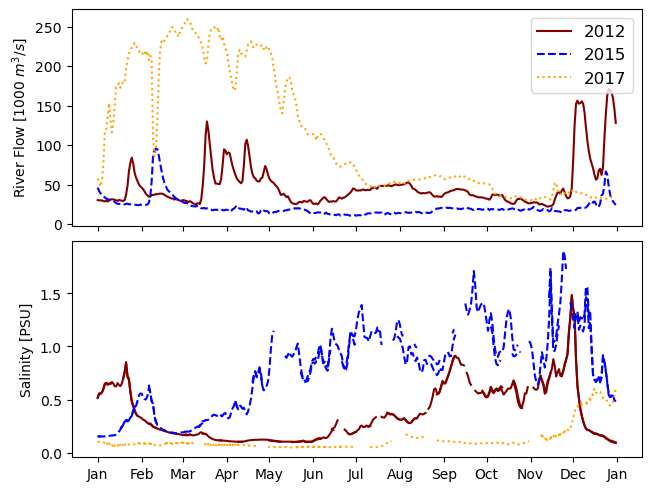

In [18]:
#plot stacked plots for jersey point salinity, on one axis and residual on another 
fig, ax = plt.subplots(2,layout="constrained",sharex=True)
mpl.rcParams.update({'font.size': 12})

ax[1].plot(jer_dms_filtc.loc['2012'].xaxis, jer_dms_filtc.loc['2012']['jer_S[psu]'], label="2012",color='maroon')
#ax[0].plot(jer_dms_filtc.loc['2012']['jer_S[mS/cm]'], label="2012",color='maroon')
ax[1].plot(sjj_dms_filtc.loc['2012'].xaxis, sjj_dms_filtc.loc['2012']['sjj_S[psu]'],color='maroon')

ax[1].plot(jer_dms_filtc.loc['2015'].xaxis, jer_dms_filtc.loc['2015']['jer_S[psu]'], label="2015",color='b',linestyle='--')
ax[1].plot(sjj_dms_filtc.loc['2015'].xaxis, sjj_dms_filtc.loc['2015']['sjj_S[psu]'], color='b',linestyle='--')

ax[1].plot(jer_dms_filtc.loc['2017'].xaxis, jer_dms_filtc.loc['2017']['jer_S[psu]'], label="2017",color='orange',linestyle=':')
ax[1].plot(sjj_dms_filtc.loc['2017'].xaxis, sjj_dms_filtc.loc['2017']['sjj_S[psu]'],color='orange',linestyle=':')

ax[1].set_ylabel("Salinity [PSU]")
#ax[1].set_ylabel("Salinity [PSU]")

# ax[1].plot(df_pr.Residual, label="Non-tidal residual", color='r')
# ax[1].set_ylabel("Elevation [m]")

ax[0].plot(fluxc.loc['2012'].xaxis,fluxc.loc['2012']['sac_sjr']*-0.001, color='maroon',label="2012")
#ax[1].plot(fluxc.loc['2012']['sac_sjr']*-1, color='maroon',label="2012")
ax[0].plot(fluxc.loc['2015'].xaxis,fluxc.loc['2015']['sac_sjr']*-0.001, color='b',linestyle='--',label="2015")
ax[0].plot(fluxc.loc['2017'].xaxis,fluxc.loc['2017']['sac_sjr']*-0.001, color='orange',linestyle=':',label="2017")
ax[0].set_ylabel("River Flow [1000 $m^3/s$]")

#Clean up the X axis
# ax[0].xaxis.set_major_formatter(
#     mdates.ConciseDateFormatter(ax[0].xaxis.get_major_locator()))
# ax[1].xaxis.set_major_formatter(
#     mdates.ConciseDateFormatter(ax[1].xaxis.get_major_locator()))
# ax[0].xaxis.set_major_locator(mdates.MonthLocator())
fmt = mdates.DateFormatter('%b')
# ax[0].xaxis.set_major_formatter(fmt)
ax[1].xaxis.set_major_locator(mdates.MonthLocator())
ax[1].xaxis.set_major_formatter(fmt)
# plt.setp(ax[0].get_xticklabels(), rotation=30);
# plt.setp(ax[1].get_xticklabels(), rotation=30);

#fig.legend(loc='outside')
#fig.legend(loc='lower left', bbox_to_anchor=(0.5, 1.05))#,
         # ncol=3, fancybox=True, #shadow=True)
#ax[1].set_xlabel('Day of Year')
ax[0].legend(loc='upper right')
#ax[0].set_xlim(datetime(2014,8,1),datetime(2015,1,1))
plt.show()
#fig.savefig('Fall_2014_stacked_plot_legend.png',dpi=400,bbox_inches='tight')
#fig.savefig('wys_stacked_plot_legend.png',dpi=400,bbox_inches='tight')

# Make a plot with 3 salinity stations 

In [19]:
#load data for the other 2 stations
dtformat = '%Y-%m-%d %H:%M:%S'
hol2_dms=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/dms_data_hol2.csv")
hol2_dms=hol2_dms.rename(columns={"screened/hol2//dwr_ncro/B95120/ec/microS/cm": "hol2_S[mS/cm]"})
hol2_dms['datetime']=pd.to_datetime(hol2_dms['datetime'],format=dtformat)
hol2_dms.set_index("datetime",inplace=True)
hol2_dms=hol2_dms.asfreq('15min')
hol2_dms_filt=filter_timeseries(hol2_dms)
dtformat = '%Y-%m-%dT%H:%M:%S'
frk=pd.read_csv('/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/frkdefault_ec_screened_2021.csv',skiprows=65)#.set_index('datetime')
frk=frk.rename(columns={"value": "frk_S[mS/cm]"})
frk['datetime']=pd.to_datetime(frk['datetime'],format=dtformat)
frk.set_index("datetime",inplace=True)
frk=frk.asfreq('15min')
frk_filt=filter_timeseries(frk)

In [20]:
#CONVERT TO PSU
hol2_dms_filt['hol2_S[psu]']=ec_psu_25c(hol2_dms_filt['hol2_S[mS/cm]'])
frk_filt['frk_S[psu]']=ec_psu_25c(frk_filt['frk_S[mS/cm]'])

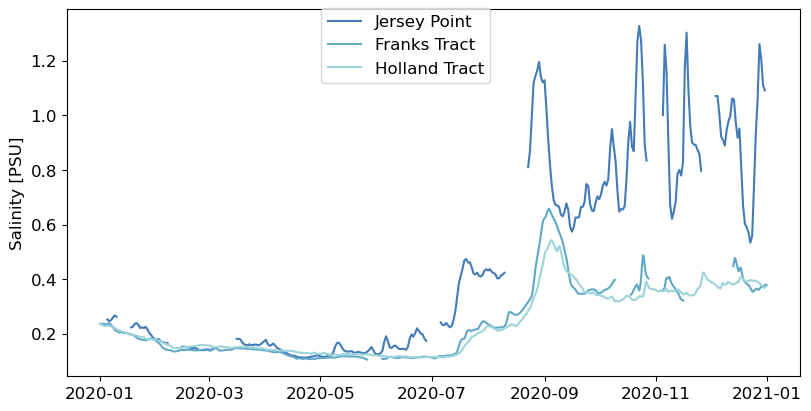

In [21]:
#use the same colors as the map station locations
colors = plt.colormaps['Dark2'].colors #this is a tuple so need to use tuple indexing [rom][column]

fig, ax = plt.subplots(layout="constrained",sharex=True,figsize=(8,4))
mpl.rcParams.update({'font.size': 12})
ax.plot(jer_dms_filtc.loc['2020']['jer_S[psu]'],label='Jersey Point',color=cmocean.cm.ice(3/6))
#ax.plot(sjj_dms_filt.loc['2020']['sjj_S[mS/cm]'],color=colors[2][:])
ax.plot(frk_filt.loc['2020']['frk_S[psu]'],label='Franks Tract',color=cmocean.cm.ice(4/6))
ax.plot(hol2_dms_filt.loc['2020']['hol2_S[psu]'],label='Holland Tract',color=cmocean.cm.ice(5/6))
#ax.set_ylabel("Salinity [mS/cm]")
ax.set_ylabel("Salinity [PSU]")

#ax.set_xlim(datetime(2013,7,1),datetime(2013,12,1))
fig.legend(loc='upper center')

# Make the stacked plots with exports and air pressure anomaly

In [22]:
# Load the psl anomaly and tide gauge data
df_m=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/sl_regression/monterey.regression.data.hourly.1996.2020.csv",parse_dates=['time']).set_index(['time'])
#Residual calculated by subtracting from utide predicted tide, see notebook /global/scratch/users/jennaisrael/climate_data_processing/sl_regression/detrended_residuals_utide.ipynb
df_pr=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/sl_regression/point_reyes.regression.data.hourly.1996.2020.csv",parse_dates=['time']).set_index(['time'])
df_m

,u10_stress_a,v10_stress_a,msl_a,sst_a,PDO_a,EN3.4_a,Residual
time,,,,,,,
1995-12-31 16:00:00,8.956125,-43.981939,736.900563,0.659997,0.836933,-1.306148,-0.041708
1995-12-31 17:00:00,5.255560,-33.640463,771.835528,0.659997,0.836933,-1.306148,-0.049622
1995-12-31 18:00:00,4.653470,-29.136661,734.585493,0.659997,0.836933,-1.306148,-0.050717
1995-12-31 19:00:00,7.100264,-24.445409,689.835457,0.659997,0.836933,-1.306148,-0.043857
1995-12-31 20:00:00,15.985210,-32.178663,623.085422,0.659997,0.836933,-1.306148,-0.056559
...,...,...,...,...,...,...,...
2021-10-01 19:00:00,-1.437500,0.301881,-145.706222,1.620365,-2.707063,-1.352207,-0.005646
2021-10-01 20:00:00,1.117509,-0.157175,-153.396257,1.620364,-2.707063,-1.352207,-0.015753
2021-10-01 21:00:00,1.308850,0.070465,-179.146292,1.620364,-2.707063,-1.352207,-0.019239


In [23]:
# load Eli's SCHA tidally filtered signal minus my 40 day box car
ptreyes=pd.read_csv("/global/scratch/users/jennaisrael/time_varying_data/tide_gauge_data/bcfiltered_SCHA_subtide_ptreyes.csv")
dtformat = '%Y-%m-%d %H:%M:%S'
ptreyes['datetime'] = pd.to_datetime(ptreyes['datetime'],format=dtformat)
pr_filt=ptreyes[['datetime','box_40d_filt']].rename(columns={"box_40d_filt": "Residual"})
#pr_filt.set_index("datetime",inplace=True)
pr_filt

,datetime,Residual
0,2012-01-03 01:30:00,NaN
1,2012-01-03 02:00:00,NaN
2,2012-01-03 02:30:00,NaN
3,2012-01-03 03:00:00,NaN
4,2012-01-03 03:30:00,NaN
...,...,...
210182,2023-12-29 20:30:00,NaN
210183,2023-12-29 21:00:00,NaN
210184,2023-12-29 21:30:00,NaN
210185,2023-12-29 22:00:00,NaN


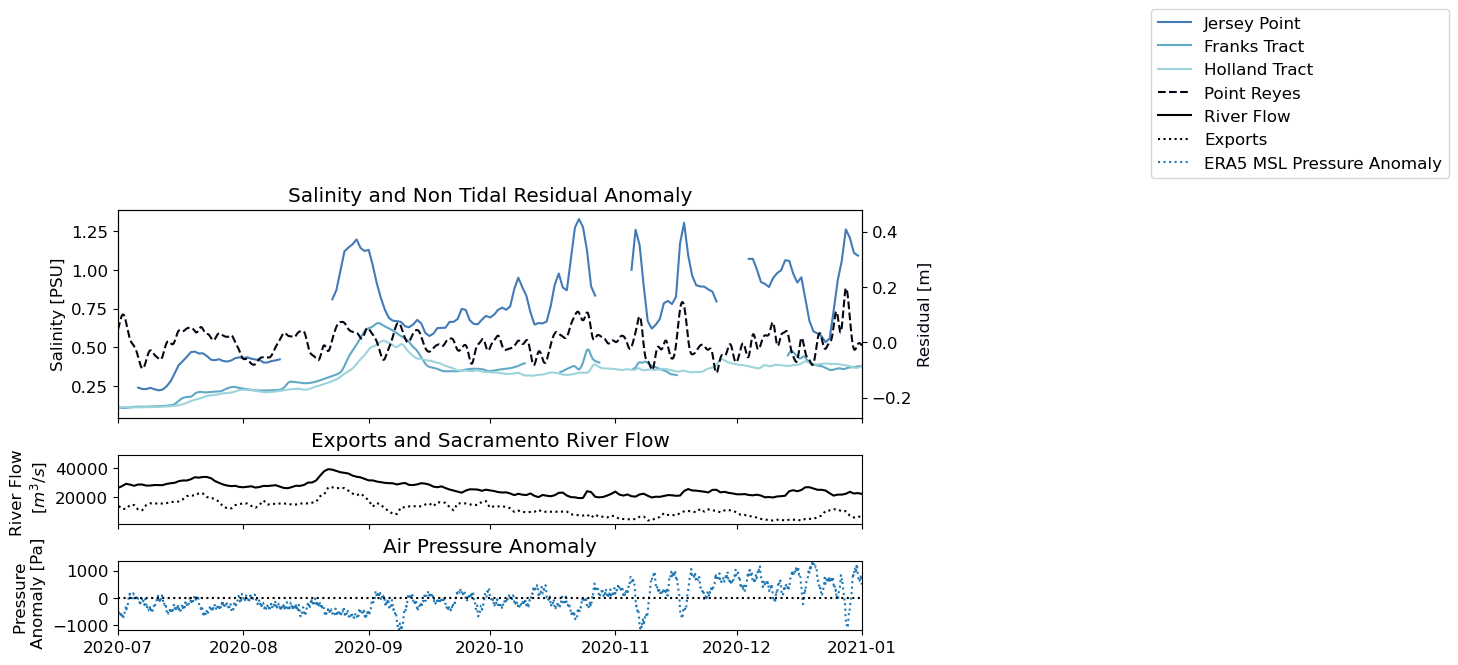

In [27]:
# Try plotting exports and river flow on a second thin subplot below the salinity and elevation plot and then a third plot for sea level pressure
fig, ax = plt.subplots(3,1,layout="constrained",sharex=True,figsize=(11,6),gridspec_kw={'height_ratios': [3, 1, 1]})

#Set the date limits of the plot HERE so I can rescale the axes by min and max in this range 
lim1=datetime(2020,7,1)
lim2=datetime(2021,1,1)
#colors to be consistent with other plors
colors = plt.colormaps['Dark2'].colors #this is a tuple so need to use tuple indexing [rom][column]
a, = ax[0].plot(jer_dms_filtc.loc['2020']['jer_S[psu]'],label='Jersey Point',color=cmocean.cm.ice(3/6)) #USBR
#add the other jersey point station to see if we can fill in 
#ax[0].plot(sjj_dms_filtc.loc['2020']['sjj_S[psu]'],color=cmocean.cm.ice(3/6)) #,label='sjj USGS'
b, = ax[0].plot(frk_filt.loc['2020']['frk_S[psu]'],label='Franks Tract',color=cmocean.cm.ice(4/6))
c, = ax[0].plot(hol2_dms_filt.loc['2020']['hol2_S[psu]'],label='Holland Tract',color=cmocean.cm.ice(5/6))
ax[0].set_ylabel("Salinity [PSU]")
ax2=ax[0].twinx()
d, = ax2.plot(pr_filt['datetime'],pr_filt['Residual'], label='Point Reyes',color=cmocean.cm.ice(0),linestyle='--')
ax2.set_ylabel("Residual [m]",color=cmocean.cm.ice(0))
#ax2.axhline(y=0, color = 'k',linestyle='--')
ax[0].set_title('Salinity and Non Tidal Residual Anomaly')
#fig.legend(loc='upper center')

e, = ax[1].plot(fluxc['sac_sjr']*-1, label="River Flow", color='k')
f, = ax[1].plot(fluxc['exports'], label="Exports", color='k',linestyle=':')
min1=fluxc[lim1:lim2][['sac_sjr','exports']].abs().min(axis=None).min()-2500
max1=fluxc[lim1:lim2][['sac_sjr','exports']].abs().max(axis=None).max()+10000
ax[1].set_ylim([min1,max1])
ax[1].set_ylabel("River Flow \n [$m^3/s$]")
ax[1].set_title('Exports and Sacramento River Flow')
#ax[1].legend()

g, = ax[2].plot(df_pr['msl_a'],label='ERA5 MSL Pressure Anomaly',linestyle=':')
min2=df_pr['msl_a'][lim1:lim2].min()-5
max2=df_pr['msl_a'][lim1:lim2].max()+5
ax[2].set_ylim([min2,max2])
ax[2].set_ylabel("Pressure \n Anomaly [Pa]")
ax[2].axhline(y=0, color = 'k',linestyle=':')
ax[2].set_title('Air Pressure Anomaly')


# # #add vertical lines for start and end of subtidal pumping events
# #start 1
# ax.axvline(x = datetime(2018,10,5), color = 'b',linestyle='--')#, label = 'axvline - full height')
# #end 1
# ax.axvline(x = datetime(2018,10,20), color = 'k',linestyle='--')
# #start 2
# ax.axvline(x = datetime(2020,10,17), color = 'b',linestyle='--')
# #end 2
# ax.axvline(x = datetime(2020,10,30), color = 'k',linestyle='--')
# #start 3
# ax.axvline(x = datetime(2020,11,23), color = 'b',linestyle='--')#, label = 'axvline - full height')
# #end 3
# ax.axvline(x = datetime(2020,12,1), color = 'k',linestyle='--')

ax[0].set_xlim(lim1,lim2)
leg = plt.legend(handles=[a,b,c,d,e,f,g],loc='upper right', bbox_to_anchor=(1.8, 2.0))
plt.show()

